# Libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator,MultipleLocator, AutoMinorLocator
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True
rcParams['font.size'] = 20

### DOS: $~~~~~\tilde{\nu}(E)=\frac{2}{\pi}\frac{E}{\sqrt{E^2-\Delta^2}\sqrt{J^2+\Delta^2-E^2}}~\Theta(E-\Delta)\Theta(\sqrt{J^2+\Delta^2}-E)$

In [3]:
def DOS(E,gap):
    return (2/PI)*E/(np.sqrt(np.abs(E**2-gap**2))*np.sqrt(np.abs(1+gap**2-E**2)))
def DOS2(E,Ep,gap):
    return (4.0/PI**2)*(E/(np.sqrt(np.abs(E**2-gap**2))*np.sqrt(np.abs(1+gap**2-E**2))))*(Ep/(np.sqrt(np.abs(Ep**2-gap**2))*np.sqrt(np.abs(1+gap**2-Ep**2))))

### Photonic spectral function: $~~~~~\mathrm{Im}D^R_{0}(q,\omega)=-\frac{\nu_0}{4\pi\nu_q}\left[\frac{\gamma_B}{(\omega-\nu_q)^2+\gamma_B^2}-\frac{\gamma_B}{(\omega+\nu_q)^2+\gamma_B^2}\right]$

In [4]:
def ImDR0(w,nu0,gammaB):
    return -(1.0/(4.0*PI))*((gammaB/((w-nu0)**2+gammaB**2))-(gammaB/((w+nu0)**2+gammaB**2)))

### Distribution factor: $~~~~~H_0(\omega,\omega')=\left[F^{T_{cry}}_0(\omega')-F^{T_{cry}}_0(\omega)\right]\left[B^{T_{cav}}_0(\omega'-\omega)-B^{T_{cry}}_0(\omega'-\omega)\right]$

In [5]:
def H0(w,wp,Tcry,Tcav):
    return (np.tanh(wp/(2*Tcry))- np.tanh(w/(2*Tcry)))*((1.0/np.tanh((wp-w)/(2*Tcav)))-(1.0/np.tanh((wp-w)/(2*Tcry))))

### Change in order parameter (Gap):
$\frac{\delta\Delta}{\Delta_0}=\frac{1}{N}\int dE\frac{\tilde{\nu}(E)}{E}~\delta F(E)$ wher the denominator $N=\int dE~\tilde{\nu}(E)\frac{\Delta_0^2}{E^2}\left[\frac{\tanh(E/2T_{cry})}{E}-\frac{\mathrm{sech}^2(E/2T_{cry})}{2T_{cry}}\right]$ 
and $\delta F(E)=-\frac{g_0^2}{2\gamma}\int~dE'\tilde{\nu}(E'\left[\left(1+\eta\frac{\Delta^2}{EE'}\right)\mathrm{Im}D^R_0(0,E'-E)H_0(E,E')-\left(1-\eta\frac{\Delta^2}{EE'}\right)\mathrm{Im}D^R_0(0,E'+E)H_0(-E,E')\right]$

In [6]:
# The Denominator
def deN_integ(E,gap,Tcry):
    return DOS(E,gap)*(gap**2/E**2)*((np.tanh(E/(2*Tcry))/E)-1.0/(2*Tcry*np.cosh(E/(2*Tcry))**2))
def deN(gap,Tcry):
    return sp.integrate.quad(deN_integ,gap,np.sqrt(1+gap**2),args=(gap,Tcry))[0]

#special case T=0
def deN_integ0(E,gap):
    return DOS(E,gap)*(gap**2/E**3)
def deN0(gap):
    return sp.integrate.quad(deN_integ,gap,np.sqrt(1+gap**2),args=(gap))[0]

#### calculates $\int dE\tilde{\nu}(E)\frac{\delta F(E)}{E}$

In [7]:
# The Numerataors
#SC
def num_integ_SC(E,Ep,gap,Tcry,Tcav,gammaB,nu0):
    return (DOS2(E,Ep,gap)/E)*((1+(gap**2)/(E*Ep))*ImDR0(Ep-E,nu0,gammaB)*H0(E,Ep,Tcry,Tcav)-(1-(gap**2)/(E*Ep))*ImDR0(Ep+E,nu0,gammaB)*H0(-E,Ep,Tcry,Tcav))
def numSC(eps,gap,Tcry,Tcav,gammaB,nu0):
    return sp.integrate.dblquad(num_integ_SC,gap,np.sqrt(1+gap**2),gap,lambda x: x,args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]+sp.integrate.dblquad(num_integ_SC,gap,np.sqrt(1+gap**2),lambda x: x,np.sqrt(1+gap**2),args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]
#CDW
def num_integ_CDW(E,Ep,gap,Tcry,Tcav,gammaB,nu0):
    return (DOS2(E,Ep,gap)/E)*((1-(gap**2)/(E*Ep))*ImDR0(Ep-E,nu0,gammaB)*H0(E,Ep,Tcry,Tcav)-(1+(gap**2)/(E*Ep))*ImDR0(Ep+E,nu0,gammaB)*H0(-E,Ep,Tcry,Tcav))
def numCDW(eps,gap,Tcry,Tcav,gammaB,nu0):
    return sp.integrate.dblquad(num_integ_CDW,gap,np.sqrt(1+gap**2),gap,lambda x: x,args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]+sp.integrate.dblquad(num_integ_CDW,gap,np.sqrt(1+gap**2),lambda x: x,np.sqrt(1+gap**2),args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]

In [8]:
#SC
def delgapSC(eps,g0,gamma,gap,Tcry,Tcav,gammaB,nu0):
    return -(g0**2/gamma)*numSC(eps,gap,Tcry,Tcav,gammaB,nu0)/deN(gap,Tcry)

In [9]:
#CDW
def delgapCDW(eps,g0,gamma,gap,Tcry,Tcav,gammaB,nu0):
    return -(g0**2/gamma)*numCDW(eps,gap,Tcry,Tcav,gammaB,nu0)/deN(gap,Tcry)

### Thermal gap equation

In [10]:
#T=0
def gapeq0_integ(E,gap):
    return DOS(E,gap)/E
def gapeq0(gap,kap):
    return sp.integrate.quad(gapeq0_integ,gap,np.sqrt(1+gap**2),args=(gap))[0]-1.0/kap
#T>0
def gap_eq_integ(E,gap,T):
    return (DOS(E,gap)/E)*np.tanh(E/(2*T))
def gap_eq(gap,T,kap):
    return sp.integrate.quad(gap_eq_integ,gap,np.sqrt(1+gap**2),args=(gap,T))[0]-1.0/kap
def gap_eq_inv(T,gap,kap):
    return sp.integrate.quad(gap_eq_integ,gap,np.sqrt(1+gap**2),args=(gap,T))[0]-1.0/kap

### Non-thermal gap equation 

In [11]:
#SC
def gap_nth_SC(gap,Tcry,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numSC(eps,gap,Tcry,Tcav,gammaB,nu0)
def gap_nth_SC_inv(Tcry,gap,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numSC(eps,gap,Tcry,Tcav,gammaB,nu0)
#CDW
def gap_nth_CDW(gap,Tcry,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numCDW(eps,gap,Tcry,Tcav,gammaB,nu0)
def gap_nth_CDW_inv(Tcry,gap,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numCDW(eps,gap,Tcry,Tcav,gammaB,nu0)

# Read data from file

In [2]:
NNU0=28
NU0list=np.zeros([NNU0])
NU0list[0]=0.001
NU0list[1]=0.01
NU0list[2]=0.02
NU0list[3]=0.025
NU0list[4]=0.03
NU0list[5]=0.04
NU0list[6]=0.05
NU0list[7]=0.075
NU0list[8]=0.100
NU0list[9]=0.125
NU0list[10]=0.150
NU0list[11]=0.160
NU0list[12]=0.170
NU0list[13]=0.175
NU0list[14]=0.180
NU0list[15]=0.190
for j in range(16,NNU0):
    NU0list[j]=(j-8)*0.025
NGAP=61
GAPlist=np.zeros([NNU0,NGAP])
TEQlist=np.zeros([NNU0,NGAP])
TSClist=np.zeros([NNU0,NGAP])
TCDWlist=np.zeros([NNU0,NGAP])

KAP=0.5
TCAV=0.2
G0=0.1
GAMMA=0.01
GAMMAB=0.5
NU0=0.02
EPS=0.00001
for j in range(0,NNU0):
    NU0=NU0list[j]
    infname=("./data/GapVsT_g%.2f_gam%.2f_gamB%.2f_Tcav%.2f_nu%.3f.dat"%(G0,GAMMA,GAMMAB,TCAV,NU0))    
    data=np.loadtxt(infname,skiprows=1)
    GAPlist[j,:]=data[:,0]
    TEQlist[j,]=data[:,1]
    TSClist[j,:]=data[:,2]
    TCDWlist[j,:]=data[:,3]


# Analyze data and find inflection points

In [ ]:
TClist=np.zeros([NNU0])
TMAXSClist=np.zeros([NNU0])
TMAXCDWlist=np.zeros([NNU0])
TMINCDWlist=np.zeros([NNU0])
TMAXSCinx=np.zeros([NNU0],dtype='int')
TMAXCDWinx=np.zeros([NNU0],dtype='int')
TMINCDWinx=np.zeros([NNU0],dtype='int')


for j in range(0,NNU0):
    TClist[j]=TSClist[j,0]
    inx=sp.signal.argrelextrema(TSClist[j,:],np.greater)[0]
    TMAXSCinx[j]=int(inx[0])
    TMAXSClist[j]=TSClist[j,inx][0]

inxh=0
NCDWH=0
for j in range(0,NNU0):
    inxh=sp.signal.argrelextrema(TCDWlist[j,:],np.greater)
    if(len(inxh[0])>0):
        NCDWH+=1
        TMAXCDWinx[j]=inxh[0]
        TMAXCDWlist[j]=TCDWlist[j,inxh[0]][0]
    else:
        break

inxl=0
NCDWL=0
for j in range(0,NNU0):
    inxl=sp.signal.argrelextrema(TCDWlist[j,:],np.less)
    if(len(inxl[0])>0):
        NCDWL+=1
        TMINCDWinx[j]=inxl[0]
        TMINCDWlist[j]=TCDWlist[j,inxl[0]][0]
    else:
        break

# Plots

/var/folders/15/xk2stb214vn3c4rfd89q4sgr0000gn/T/ipykernel_80177/861467019.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1920x1440 with 0 Axes>

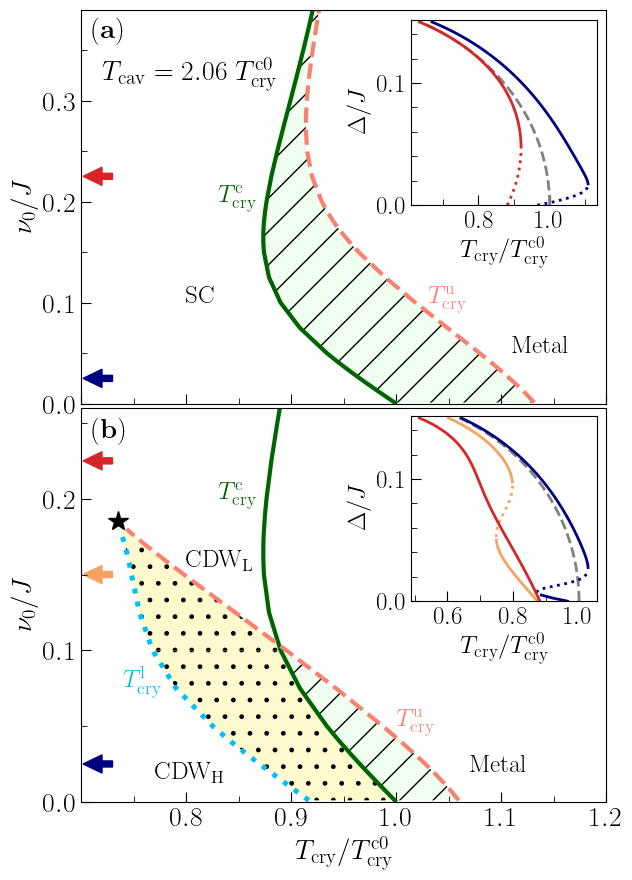

In [5]:
%matplotlib inline
plt.figure(3,dpi=300)
plt.rcParams.update({'font.size':20})

clrs=['deepskyblue','darkgreen','saddlebrown','navy']
lw=3.0
clrs=plt.cm.viridis_r(np.linspace(0.2,0.9,3))

TC0=TEQlist[1,0]

fig,ax=plt.subplots(2,1,figsize=(54/8,9))
xmax=1.08
xmin=0.7
ymax=0.26
ymin=-0.02
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

k1=3
k2=17
ax[0].set_xlim(0.7,1.2)
ax[0].set_ylim(0.0,0.39)
ax[0].plot(TClist[:25]/TC0,NU0list[:25],'-',color='darkgreen',linewidth=lw,markersize=10,label=r"2nd order $T^{ \mathrm{c}}_{\mathrm{cry}}$")
ax[0].plot(TMAXSClist[0:25]/TC0,NU0list[0:25],'--',color='salmon',linewidth=lw,markersize=10,label=r"1st order $T^{ \mathrm{c}}_{\mathrm{cry}}$")
ax[0].fill_betweenx(NU0list[0:25],TClist[0:25]/TC0,TMAXSClist[0:25]/TC0,facecolor='honeydew',hatch='/')

ax[0].set_ylabel(r'$\nu_0/J$')
ax[0].text(1.11,0.05,r"$\mathrm{Metal}$",fontsize=18)
ax[0].text(0.8,0.1,r"$\mathrm{SC}$",fontsize=18)
ax[0].text(0.83,0.2,r"$T^{\mathrm{c}}_\mathrm{cry}$",color='darkgreen',fontsize=18)
ax[0].text(1.03,0.1,r"$T^{\mathrm{u}}_\mathrm{cry}$",color='salmon',fontsize=18)
ax[0].arrow(0.73,NU0list[k1],-0.01,0.0,width=0.006,head_width=0.018,head_length=0.018,color='navy')
ax[0].arrow(0.73,NU0list[k2],-0.01,0.0,width=0.006,head_width=0.018,head_length=0.018,color='tab:red')
ax[0].text(0.71,0.362,r'$\mathbf{(a)}$')
ax[0].text(0.72,0.32,r'$T_{\mathrm{cav}}=%.2f~T^{\mathrm{c}0}_{\mathrm{cry}}$'%(TCAV/TC0))


ax[0].set_xticklabels([])
ax[0].tick_params(which='major',direction='in', length=7)
ax[0].tick_params(which='minor',direction='in', length=4)
ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_box_aspect(0.75)


ax0=fig.add_axes([0.64,0.715,0.275,0.275])
ax0.set_ylim(0.0,0.152)
ax0.plot(TEQlist[6,:]/TC0,GAPlist[6,:],'--',color='grey',linewidth=2,label="EQ")
ax0.plot(TSClist[k1,:TMAXSCinx[k1]]/TC0,GAPlist[k1,:TMAXSCinx[k1]],':',color='navy',markersize=8,linewidth=2)
ax0.plot(TSClist[k1,TMAXSCinx[k1]:]/TC0,GAPlist[k1,TMAXSCinx[k1]:],'-',color='navy',markersize=8,linewidth=2)
ax0.plot(TSClist[k2,:TMAXSCinx[k2]]/TC0,GAPlist[k2,:TMAXSCinx[k2]],':',color='tab:red',markersize=8,linewidth=2)
ax0.plot(TSClist[k2,TMAXSCinx[k2]:]/TC0,GAPlist[k2,TMAXSCinx[k2]:],'-',color='tab:red',markersize=8,linewidth=2)
ax0.set_xlabel(r'$T_{\mathrm{cry}}/T^{\mathrm{c}0}_{\mathrm{cry}}$',fontsize=18)
ax0.set_ylabel(r'$\Delta/J$',fontsize=18)
ax0.tick_params(which='major',direction='in', length=7,labelsize=18)
ax0.tick_params(which='minor',direction='in', length=4)
ax0.xaxis.set_major_locator(MultipleLocator(0.2))
ax0.xaxis.set_minor_locator(MultipleLocator(0.1))
ax0.yaxis.set_major_locator(MultipleLocator(0.1))
ax0.yaxis.set_minor_locator(MultipleLocator(0.02))
ax0.set_box_aspect(1)




k4=3
k5=10
k6=17
ax[1].set_xlim(0.7,1.2)
ax[1].set_ylim(0.0,0.26)
ax[1].plot(TClist[:20]/TC0,NU0list[:20],'-',color='darkgreen',linewidth=lw,markersize=10,label=r"2nd order $T^{ \mathrm{c}}_{\mathrm{cry}}$")
ax[1].plot(TMAXCDWlist[0:NCDWH]/TC0,NU0list[0:NCDWH],'--',color='salmon',linewidth=lw,markersize=10,label=r"1st order $T^{ \mathrm{c}}_{\mathrm{cry}}$")
ax[1].plot(TMINCDWlist[0:NCDWL]/TC0,NU0list[0:NCDWL],':',color='deepskyblue',linewidth=lw*1.2,markersize=10,label=r"1st order $T^{ \mathrm{c}}_{\mathrm{cry}}$")
ax[1].fill_betweenx(NU0list,TClist/TC0,TMAXCDWlist/TC0,where = (NU0list > 0.0) & (NU0list <=0.1),facecolor='honeydew',hatch='/')
ax[1].fill_betweenx(NU0list,TMINCDWlist/TC0,TMAXCDWlist/TC0,where = (NU0list > 0.09) & (NU0list <=0.185),facecolor='lemonchiffon',hatch='.')
ax[1].fill_betweenx(NU0list,TMINCDWlist/TC0,TClist/TC0,where = (NU0list > 0.0) & (NU0list <=0.1),facecolor='lemonchiffon',hatch='.')
ax[1].plot(0.735,0.185,'*',markersize=15,color='black')



ax[1].set_xlabel(r'$T_{\mathrm{cry}}/T^{\mathrm{c}0}_{\mathrm{cry}}$')
ax[1].set_ylabel(r'$\nu_0/J$')
#plt.legend(loc='best',fontsize=18)
ax[1].text(1.07,0.02,r"$\mathrm{Metal}$",fontsize=18)
ax[1].text(0.77,0.015,r"$\mathrm{CDW_H}$",fontsize=18)
ax[1].text(0.8,0.155,r"$\mathrm{CDW_L}$",fontsize=18)
ax[1].text(0.83,0.2,r"$T^{\mathrm{c}}_\mathrm{cry}$",color='darkgreen',fontsize=18)
ax[1].text(1.0,0.05,r"$T^{\mathrm{u}}_\mathrm{cry}$",color='salmon',fontsize=18)
ax[1].text(0.74,0.075,r"$T^{\mathrm{l}}_\mathrm{cry}$",color='deepskyblue',fontsize=18)
ax[1].arrow(0.73,NU0list[k4],-0.01,0.0,width=0.004,color='navy')
ax[1].arrow(0.73,NU0list[k5],-0.01,0.0,width=0.004,color='sandybrown')
ax[1].arrow(0.73,NU0list[k6],-0.01,0.0,width=0.004,color='tab:red')
ax[1].text(0.71,0.24,r'$\mathbf{(b)}$')

ax[1].tick_params(which='major',direction='in', length=7)
ax[1].tick_params(which='minor',direction='in', length=4)
ax[1].xaxis.set_major_locator(MultipleLocator(0.1))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.05))
#ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_major_locator(MultipleLocator(0.1))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
#ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xticks([0.8,0.9,1.0,1.1,1.2])
ax[1].set_box_aspect(0.75)


ax1=fig.add_axes([0.64,0.275,0.275,0.275])
ax1.set_ylim(0.0,0.152)
ax1.plot(TEQlist[6,:]/TC0,GAPlist[6,:],'--',color='grey',linewidth=2,label="EQ")
ax1.plot(TCDWlist[k4,:TMINCDWinx[k4]]/TC0,GAPlist[k4,:TMINCDWinx[k4]],'-',color='navy',markersize=8,linewidth=2)
ax1.plot(TCDWlist[k4,TMINCDWinx[k4]:TMAXCDWinx[k4]]/TC0,GAPlist[k4,TMINCDWinx[k4]:TMAXCDWinx[k4]],':',color='navy',markersize=8,linewidth=2)
ax1.plot(TCDWlist[k4,TMAXCDWinx[k4]:]/TC0,GAPlist[k4,TMAXCDWinx[k4]:],'-',color='navy',markersize=8,linewidth=2)
ax1.plot(TCDWlist[k5,:TMINCDWinx[k5]]/TC0,GAPlist[k5,:TMINCDWinx[k5]],'-',color='sandybrown',markersize=8,linewidth=2)
ax1.plot(TCDWlist[k5,TMINCDWinx[k5]:TMAXCDWinx[k5]+1]/TC0,GAPlist[k5,TMINCDWinx[k5]:TMAXCDWinx[k5]+1],':',color='sandybrown',markersize=8,linewidth=2)
ax1.plot(TCDWlist[k5,TMAXCDWinx[k5]+1:]/TC0,GAPlist[k5,TMAXCDWinx[k5]+1:],'-',color='sandybrown',markersize=8,linewidth=2)
ax1.plot(TCDWlist[k6,:]/TC0,GAPlist[k6,:],'-',color='tab:red',markersize=8,linewidth=2)
ax1.set_xlabel(r'$T_{\mathrm{cry}}/T^{\mathrm{c}0}_{\mathrm{cry}}$',fontsize=18)
ax1.set_ylabel(r'$\Delta/J$',fontsize=18)
ax1.tick_params(which='major',direction='in', length=7,labelsize=18)
ax1.tick_params(which='minor',direction='in', length=4)
ax1.xaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.02))
ax1.set_box_aspect(1)

plt.subplots_adjust(hspace=-0.4)
plt.tight_layout()
plt.savefig("./plots/phasediagram_panel1.pdf",dpi=300)
plt.show()